In [60]:
import os
from math import sqrt
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import YouTubeVideo, display

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import Accuracy, MeanMetric

from torchvision.datasets import MNIST, ImageNet, CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, RandomAffine
from torchvision.utils import make_grid

## Implementation 

### Tokenization and Embedding

In [61]:
class PatchEmbedding(nn.Module):
    
    def __init__(self, img_size, patch_size, input_channels, output_channels):
        """Constructor of PatchEmbedding module
        
        Args:
            img_size (tuple): 2D tuple specifying the image dimensions (H, W)
            patch_size (tuple): 2D tuple specifying the patch dimensions (p_h, p_w)
            input_channels (int): Number of channels of the input image
            output_channels (int): Number of output channels of the 2D 
                convolution  / Dimension of the patch embeddings.
        """
        super().__init__()
        self.output_channels = output_channels
        h, w = img_size
        patch_h, patch_w = patch_size

        assert h % patch_h == 0 and w % patch_w == 0, "img size must be divisible per patch_size"

        
        self.patch_emb = nn.Conv2d(
            in_channels=input_channels, 
            out_channels=output_channels, 
            kernel_size=patch_size, 
            stride=patch_size)
        
        self.num_patches = h // patch_h * w // patch_w

    def forward(self, x):
        """Forward pass of PatchEmbedding module
        
        Args:
            x (torch.Tensor): Batch of images with shape 
                (batch_size, input_channels, H, W) 
        
        Returns:
            torch.Tensor: Embbeded patches with shape 
                (batch_size, num_patches, output_channels)
        """

        tokens = self.patch_emb(x) 
        tokens = tokens.reshape([x.size(0), self.output_channels, -1])
        tokens = tokens.swapaxes(1, 2)
    
        return tokens

In [62]:
# Let's define a random image of one channel and size 32x32
batch_size = 1
input_channels = 1
img_size = (32, 32)
images = torch.randn(batch_size, input_channels, *img_size)
print(f'images: {images.shape}')

# Apply tokenization + embedding
embedding_dim = 16
patch_emb = PatchEmbedding(
    img_size=img_size, 
    patch_size=(4, 4), 
    input_channels=input_channels, 
    output_channels=embedding_dim)
embedded_patches = patch_emb(images)

assert tuple(embedded_patches.shape) == (batch_size, patch_emb.num_patches, embedding_dim),\
    f'Computed embedded shape {tuple(embedded_patches.shape)} does not match the expected shape {(batch_size, patch_emb.num_patches, embedding_dim)}'

print(f'embedded_patches: {embedded_patches.shape}')

images: torch.Size([1, 1, 32, 32])
embedded_patches: torch.Size([1, 64, 16])


### Positional embeddings and prepend class token

In [63]:
class AddPositionalEmbeddings(nn.Module):

    def __init__(self, num_tokens, patch_emb_dim):
        """Constructor of AddPositionalEmbeddings module
        
        Args:
            num_tokens (int): Number of tokens
            patch_emb_dim (int): Dimension of patch embeddings
        """

        super().__init__()
        self.pos_emb = nn.Parameter(
            torch.randn(1, num_tokens, patch_emb_dim))

    def forward(self, tokens):
        """Forward pass of AddPositionalEmbeddings module that should add the 
        positional embeddings to the tokens.
        
        Args:
            tokens (torch.Tensor): Tokens with shape 
                (batch_size, num_tokens, patch_emb_dim)
        
        Returns:
            torch.Tensor: Tokens with positional embeddings and shape 
                (batch_size, num_tokens, patch_emb_dim).
        """
        
        tokens = tokens + self.pos_emb
        return tokens    

In [6]:
class PrependClassToken(nn.Module):

    def __init__(self, patch_emb_dim):
        """Constructor of PrependClassToken module
        
        Args:
            patch_emb_dim (int): Dimension of patch embeddings
        """

        super().__init__()
        self.cls_token = nn.Parameter(
            torch.randn(patch_emb_dim))

    def forward(self, tokens):
        """Forward pass of PrependClassToken module that should prepend the 
        class token to the tokens.
        
        Args:
            tokens (torch.Tensor): Tokens with shape 
            (batch_size, num_patches, patch_emb_dim)
        
        Returns:
            torch.Tensor: Concatenated class token and tokens with 
            shape (batch_size, 1+num_patches, patch_emb_dim).
        """
        cls_token = self.cls_token[None, None, ...]

        # Repeat batch_size times the class token along batch axis
        batch_size = tokens.size(0) 
        cls_token = cls_token.repeat([batch_size, 1, 1])

        # Prepend class tokens to tokens 
        tokens = torch.cat([cls_token, tokens], dim=1)
        return tokens

### Transformer encoder and Transfomer block

In [64]:
class MultiHeadSelfAttention(nn.Module):

    """Class implementing the multi-head self-attention
    
    Attributes:
        dim_head (int): Query, key, value dimension for single-head
        heads (int): Number of heads
        to_qkv (nn.Linear): Fully connected layer projecting a token into all
            (queries, keys, values) for all heads. So the output dimension is
            3 * heads * dim_head.              
        to_out (nn.Linear): Fully connected layer projecting Z' into Z''
    """
    
    def __init__(self, in_token_dim, dim_head, heads):
        """Constructor of the MultiHeadSelfAttention Module
        
        Args:
            in_token_dim (int): Input tokens dimension
            dim_head (int): Query, key, value dimension for single-head
            heads (int): Number of heads
        """
        super().__init__()
        self.dim_head = dim_head
        self.heads = heads
        out_dim = heads * dim_head
        self.to_qkv = nn.Linear(in_token_dim, 3 * out_dim)
        self.to_out = nn.Linear(out_dim, in_token_dim)
        
    def forward(self, tokens):
        """Forward pass of the MultiHeadSelfAttention Module
        
        Args:
            tokens (torch.Tensor): Tokens with shape 
                (batch_size, num_patches, in_token_dim)
        
        Returns:
            tuple: (
                Output tokens with shape (batch_size, num_tokens, in_token_dim),
                Attention maps with shape (batch_size, heads, num_tokens, num_tokens)
                ) 
        """
        # Computes queries, keys and values for all heads 
        # (batch_size, tokens, 3 * heads * dim_head)
        qkv = self.to_qkv(tokens)
        # Split qkv into queries, keys and values
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Reshape queries, keys and values (batch_size, tokens, heads * dim_head) into 
        # (batch_size, tokens, dim_head, heads)
        bs, num_tokens = q.shape[:-1]
        q = q.reshape([bs, num_tokens, self.heads, self.dim_head])
        k = k.reshape([bs, num_tokens, self.heads, self.dim_head])
        v = v.reshape([bs, num_tokens, self.heads, self.dim_head])
        
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 3, 1)
        
        # Computes attention matrix per head (batch_size, heads, tokens, tokens)
        atts = q @ k
        # Divide attention by scale (1 / sqrt(dim_head))
        atts = atts/sqrt(self.dim_head)
        # Normalize attention with softmax
        atts = atts.softmax(dim=-1)
        
        # Reshape attentions into (batch_size, heads, tokens, dim_head)
        v = v.permute(0, 2, 1, 3)
        out = atts @ v
        # Concatenate head representations. Output tensor must have (batch_size, tokens, heads * dim_head) 
        out = out.permute(0, 2, 1, 3).flatten(start_dim=2)
        out = self.to_out(out)
        
        return out, atts

In [65]:
class MLP(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        """Constructor of MLP module used in the multi-head self-attention

        Args:
            in_dim (int): Dimension of input tokens 
            hidden_dim (int): Hidden dimension of MLP
            out_dim (int): Dimension of output tokens
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, tokens):
        """Forward pass of the MLP
        
        Args:
            tokens (torch.Tensor): Input tokens with shape 
                (batch_size, in_dim, num_tokens)
        
        Returns:
            torch.Tensor: Ouput tokens with shape 
                (batch_size, out_dim, num_tokens)
        """
        return self.net(tokens)

In [66]:
class TransformerBlock(nn.Module):
    
    def __init__(self, in_dim, dim_head, heads, mlp_hid_dim):
        """Constructor of TransformerBlock module
        
        Args:
            in_dim (int): Dimension of input tokens
            dim_head (int): Dimension of the query, key and value produced by a single-head 
                self-attention
            heads (int): Number of heads to run in parallel
            mlp_hid_dim (int): Hidden dimension of MLP
        """
        super().__init__()
        self.ln1 = nn.LayerNorm(in_dim)
        self.multi_head_self_att = MultiHeadSelfAttention(
            in_dim, dim_head, heads)
        self.ln2 = nn.LayerNorm(in_dim)
        self.mlp = MLP(in_dim, mlp_hid_dim, in_dim)
        
    def forward(self, tokens):
        """Forward pass of the TransformerBlock
        
        Args:
            tokens (torch.Tensor): Input tokens with shape 
                (batch_size, in_dim, num_tokens)
        
        Returns:
            tuple: (
                Output tokens with shape (batch_size, num_tokens, in_dim),
                Attention maps with shape (batch_size, heads, num_tokens, num_tokens)
                )
        """
        out, atts = self.multi_head_self_att(self.ln1(tokens))
        # Apply residual connection
        out = out + tokens
        # Apply layer norm + MLP + residual connection
        out = self.mlp(self.ln2(out)) + out
        return out, atts

### MLP head

In [67]:
class MLPHead(nn.Module):
    
    def __init__(self, in_dim, num_classes):
        """Constructor of MLPHead module
        
        Args:
            in_dim (int): Dimension of the class token output 
                representation
            num_classes (int): Number of classes to predict
        """
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
        
    def forward(self, cls_token):
        """Forward pass of the MLPHead
        
        Args:
            cls_token (torch.Tensor): Class tokens output representations with
                shape (batch_size, in_dim)
        
        Returns:
            torch.Tensor: Classes logits with shape (batch_size, num_classes)
        """
        return self.fc(cls_token)


### Build the whole ViT

In [68]:
class ViT(nn.Module):

    """Class implementing the ViT architecture
    """
    
    def __init__(self,
                 img_size,
                 patch_size,
                 input_channels,
                 patch_emb_dim,
                 depth,
                 heads,
                 mlp_hid_dim,
                 num_classes):
        """Constructor of ViT module
        
        Args:
            img_size (tuple): Image size (H, W)
            patch_size (tuple): Path size (p_h, p_w)
            input_channels (int): Number of channels of input images
            patch_emb_dim (int): Dimension of the patch embedding
            depth (int): Number of transformer blocks
            heads (int): Number of head for each transformer block
            mlp_hid_dim (int): Hidden layer dimension in the MLP
            num_classes (int): Number of classes to predict
        """
        super().__init__()
        
        self.patch_embedding = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            input_channels=input_channels,
            output_channels=patch_emb_dim,)

        self.prepend_cls_token = PrependClassToken(patch_emb_dim)

        self.add_pos_emb = AddPositionalEmbeddings(
            num_tokens=self.patch_embedding.num_patches + 1,
            patch_emb_dim=patch_emb_dim)

        self.transformer_encoder = nn.ModuleList([TransformerBlock(
            in_dim=patch_emb_dim, 
            dim_head=patch_emb_dim//heads, 
            heads=heads, 
            mlp_hid_dim=mlp_hid_dim) for _ in range(depth)])
        
        self.norm_layer = nn.LayerNorm(patch_emb_dim)

        self.mlp_head = MLPHead(
            in_dim=patch_emb_dim, 
            num_classes=num_classes)
        ###########

    def forward(self, x):
        """Forward pass of the ViT
        
        Args:
            x (torch.Tensor): Images with shape 
                (batch_size, input_channels, H, W)
        
        Returns:
            tuple: (
                Output logits eith shape (batch_size, num_classes),
                Output tokens with shape (batch_size, num_tokens, patch_emb_dim),
                List of attention maps for each transformer block. 
                    Each element of the list (attention maps) has shape 
                    (batch_size, heads, num_tokens, num_tokens)
                ) 
        """
        tokens = self.patch_embedding(x)
        
        tokens = self.prepend_cls_token(tokens)

        tokens = self.add_pos_emb(tokens)

        # Apply consecutive transformer block
        attentions = []
        for transformer_block in self.transformer_encoder:
            tokens, atts = transformer_block(tokens)
            attentions.append(atts)
        
        tokens = self.norm_layer(tokens)

        cls_tokens = tokens[:, 0]
        pred = self.mlp_head(cls_tokens)

        return pred, tokens, attentions


In [69]:
# Let's check if the dimensions are correct for a random image of size 32x32 with one channel
batch_size = 1
img_size = (32,32)
patch_size = (4, 4)
input_channels = 1
patch_emb_dim = 32
depth = 3 
heads = 4
mlp_hid_dim = 8
num_classes = 5

# Define ViT
vit = ViT(
    img_size=img_size,
    patch_size=patch_size,
    input_channels=input_channels,
    patch_emb_dim=patch_emb_dim,
    depth=depth,
    heads=heads,
    mlp_hid_dim=mlp_hid_dim,
    num_classes=num_classes)

# Get predictions + display dimensions
x = torch.randn(batch_size, input_channels, *img_size)
pred, out, atts = vit(x)
print(f'pred: {pred.shape}')
print(f'out: {out.shape}')
print(f'atts: {[a.shape for a in atts]}')

pred: torch.Size([1, 5])
out: torch.Size([1, 65, 32])
atts: [torch.Size([1, 4, 65, 65]), torch.Size([1, 4, 65, 65]), torch.Size([1, 4, 65, 65])]


## Train ViT on MNIST 

In [13]:
# Define ViT hyperparameters
img_size = (32, 32)
patch_size = (4, 4)
input_channels = 1
patch_emb_dim = 32
depth = 4 
heads = 8
mlp_hid_dim = 32
num_classes = 10

# Define optimization hyperparameters
batch_size = 64
lr = 1e-3
epochs = 20
device = torch.device('mps') 

In [14]:
# Initialize data transformation for train and test
train_transform = Compose([
    ToTensor(),
    Resize(img_size),
    RandomAffine(degrees=0, translate=[0.05, 0.05])
])
test_transform = Compose([
    ToTensor(),
    Resize(img_size),
])


# Create train and test pytorch datasets
train_dataset_mnist = MNIST(root='.', train=True, download=True, transform=train_transform)
test_dataset_mnist = MNIST(root='.', train=False, download=True, transform=test_transform)

# Create train and test dataloaders
train_dataloader_mnist = DataLoader(
    dataset=train_dataset_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=10)
test_dataloader_mnist = DataLoader(
    dataset=test_dataset_mnist,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=10)

# Create ViT
vit = ViT(
    img_size=img_size,
    patch_size=patch_size,
    input_channels=input_channels,
    patch_emb_dim=patch_emb_dim,
    depth=depth,
    heads=heads,
    mlp_hid_dim=mlp_hid_dim,
    num_classes=num_classes).to(device)

# Define optimizer 
optimizer = Adam(params=vit.parameters(), lr=lr)

# Define cosine decay learning rate scheduler
lr_scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


img: torch.Size([1, 32, 32])
label: 5


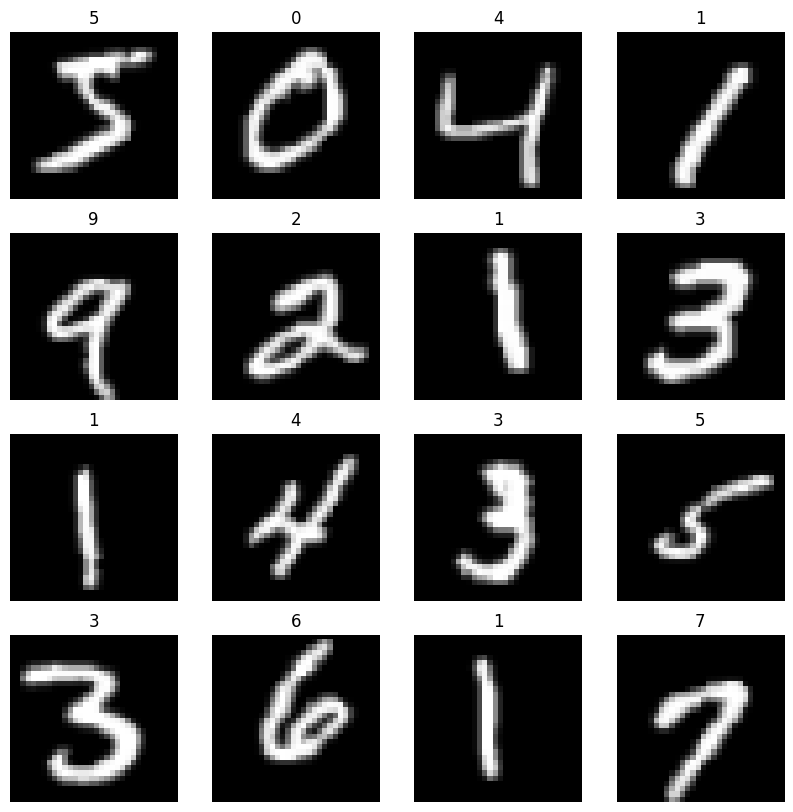

In [70]:
# Print a random image from the train dataset and its size
img, label = train_dataset_mnist[0]
print(f'img: {img.shape}')
print(f'label: {label}')

# Display 16 random images from the train dataset with label as the title
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img, label = train_dataset_mnist[i]
    ax.imshow(img[0], cmap='gray')
    ax.set_title(label)
    ax.axis('off')

### Training

In [17]:
# Create torchmetrics metrics to keep track of loss and accuracy during training
mean_loss = MeanMetric().to(device)
train_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
accuracies = []
losses = []

for epoch in range(1, epochs+1):
    
    # Create tqdm progress bar to display epoch progress and metrics
    pbar = tqdm(train_dataloader_mnist, unit='batches')
    for X, y in pbar:
        # Zero-out gradients of optimizer
        optimizer.zero_grad()
        
        # Move data to appropriate device
        X = X.to(device)
        y = y.to(device)
    
        # Make predictions
        y_pred, *_ = vit(X)
        loss = F.cross_entropy(input=y_pred, target=y)
        
        # Compute loss gradients with respect to parameters 
        loss.backward()
        mean_loss.update(loss)
        train_acc.update(y_pred, y)
        
        pbar.set_description(
            'Epoch {}/{}: Loss: {:.3f}, Acc: {:.3f}, lr: {:.5f}'.format(
                epoch,
                epochs,
                mean_loss.compute().item(),
                train_acc.compute().item() * 100,
                lr_scheduler.get_last_lr()[0]))
        
        # Update parameters
        optimizer.step()
        
    # Update learning rate
    lr_scheduler.step()
    
    # Store accuracy for this epoch
    accuracies.append(train_acc.compute().item())
    losses.append(mean_loss.compute().item())

    # Reset average metrics for next epoch
    mean_loss.reset()
    train_acc.reset()

  0%|          | 0/937 [00:00<?, ?batches/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), e

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

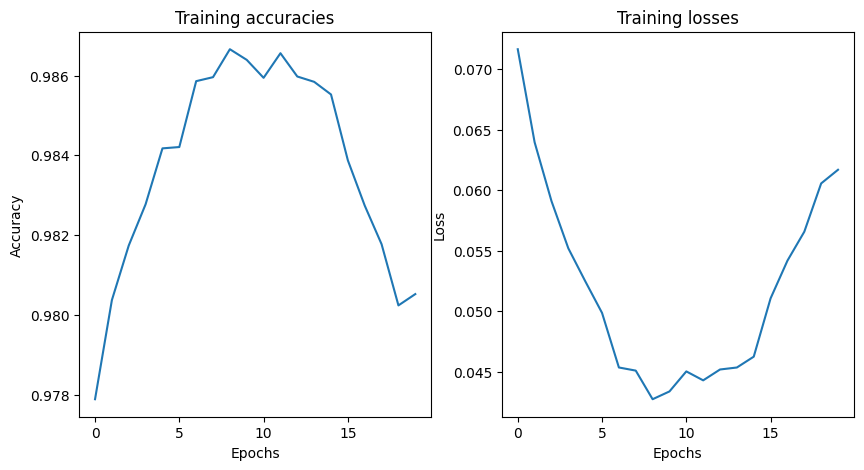

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(accuracies)
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[1].plot(losses)
axs[1].set_title('Training losses')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

### Evaluation

In [ ]:
vit = vit.eval()

test_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
with torch.no_grad():
    
    preds = []
    targets = []
    for X, y in tqdm(test_dataloader_mnist):

        # Zero-out gradients of optimizer
        optimizer.zero_grad()

        # Move data to appropriate device
        X = X.to(device)
        y = y.to(device)

        # Make predictions
        y_pred, tokens, atts = vit(X)
        
        # Update acc metric
        test_acc.update(y_pred, y)
    
print(f'Test accuracy: {test_acc.compute()}')

  0%|          | 0/938 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias

Test accuracy: 0.9810667037963867


## Train ViT on CIFAR10

In [ ]:
# Define ViT hyperparameters
img_size = (32, 32)
patch_size = (4, 4)
input_channels = 3
patch_emb_dim = 32
depth = 4 
heads = 8
mlp_hid_dim = 32
num_classes = 10

# Define optimization hyperparameters
batch_size = 64
lr = 1e-3
epochs = 20
device = torch.device('mps') 

In [20]:
# Initialize data transformation for train and test
train_transform = Compose([
    ToTensor(),
    Resize(img_size),
    RandomAffine(degrees=0, translate=[0.05, 0.05])
])
test_transform = Compose([
    ToTensor(),
    Resize(img_size),
])


# Create train and test pytorch datasets
train_dataset_cifar = CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dataset_cifar = CIFAR10(root='.', train=False, download=True, transform=test_transform)

# Create train and test dataloaders
train_dataloader_cifar = DataLoader(
    dataset=train_dataset_cifar,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=10)
test_dataloader_cifar = DataLoader(
    dataset=train_dataset_cifar,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=10)

# Create ViT
vit = ViT(
    img_size=img_size,
    patch_size=patch_size,
    input_channels=input_channels,
    patch_emb_dim=patch_emb_dim,
    depth=depth,
    heads=heads,
    mlp_hid_dim=mlp_hid_dim,
    num_classes=num_classes).to(device)

# Define optimizer 
optimizer = Adam(params=vit.parameters(), lr=lr)

# Define cosine decay learning rate scheduler
lr_scheduler = CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs)

Files already downloaded and verified
Files already downloaded and verified


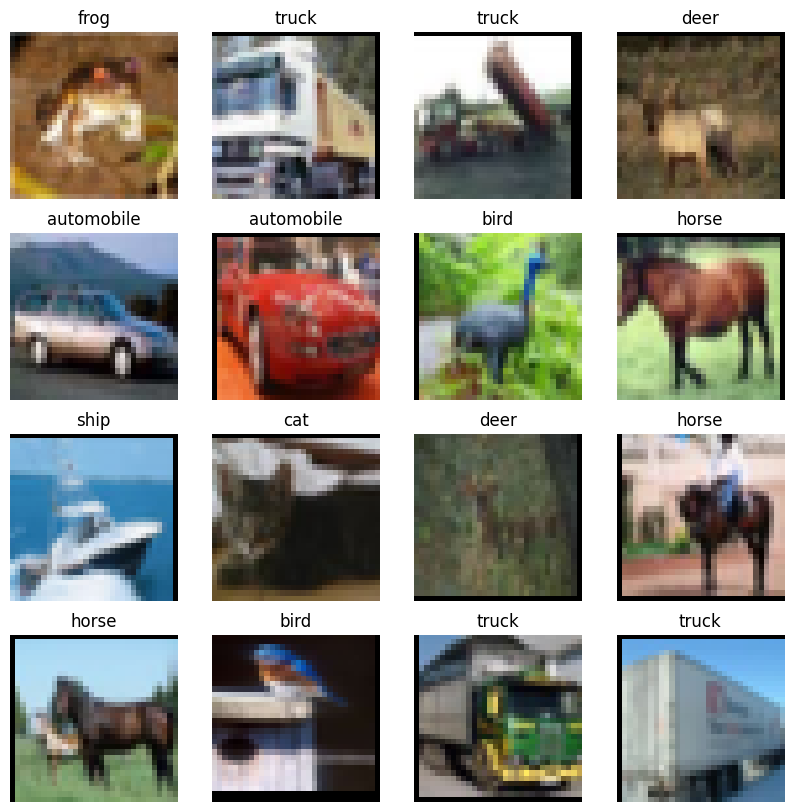

In [74]:
id2label = {i: label for i, label in enumerate(train_dataset_cifar.classes)}
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img, label = train_dataset_cifar[i]
    ax.imshow(img.permute(1, 2, 0).squeeze())
    ax.set_title(id2label[label])
    ax.axis('off')
    

### Training

In [ ]:
# Create torchmetrics metrics to keep track of loss and accuracy during training
mean_loss = MeanMetric().to(device)
train_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
accuracies = []
losses = []

for epoch in range(1, epochs+1):
    
    # Create tqdm progress bar to display epoch progress and metrics
    pbar = tqdm(train_dataloader_cifar, unit='batches')
    for X, y in pbar:
        # Zero-out gradients of optimizer
        optimizer.zero_grad()
        
        # Move data to appropriate device
        X = X.to(device)
        y = y.to(device)
    
        # Make predictions
        y_pred, *_ = vit(X)
        loss = F.cross_entropy(input=y_pred, target=y)
        
        # Compute loss gradients with respect to parameters 
        loss.backward()
        mean_loss.update(loss)
        train_acc.update(y_pred, y)
        
        pbar.set_description(
            'Epoch {}/{}: Loss: {:.3f}, Acc: {:.3f}, lr: {:.5f}'.format(
                epoch,
                epochs,
                mean_loss.compute().item(),
                train_acc.compute().item() * 100,
                lr_scheduler.get_last_lr()[0]))
        
        # Update parameters
        optimizer.step()
        
    # Update learning rate
    lr_scheduler.step()

    accuracies.append(train_acc.compute().item())
    losses.append(mean_loss.compute().item())
    
    # Reset average metrics for next epoch
    mean_loss.reset()
    train_acc.reset()

  0%|          | 0/781 [00:00<?, ?batches/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Text(0, 0.5, 'Loss')

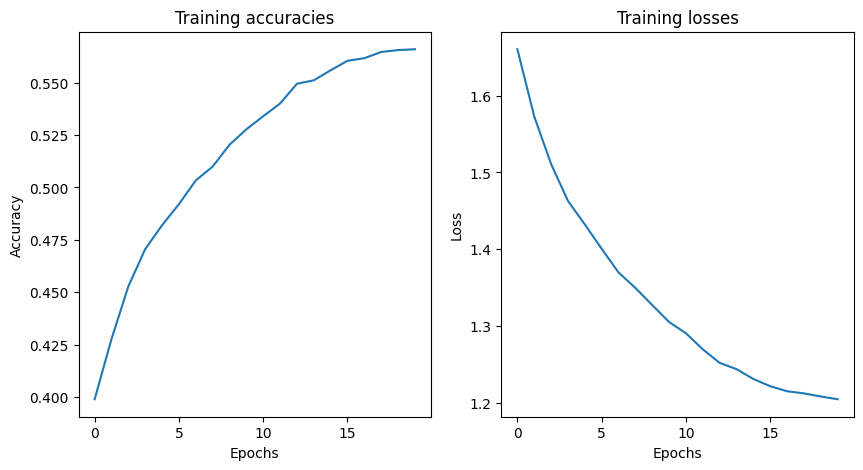

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(accuracies)
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[1].plot(losses)
axs[1].set_title('Training losses')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

### Evaluation

In [ ]:
vit = vit.eval()

# make sure that no intermediate values in the network 
# are stored for gradients computation
test_acc = Accuracy(task='multiclass', num_classes=num_classes).to(device)
with torch.no_grad():
    
    preds = []
    targets = []
    for X, y in tqdm(test_dataloader_cifar):

        # Zero-out gradients of optimizer
        optimizer.zero_grad()

        # Move data to appropriate device
        X = X.to(device)
        y = y.to(device)

        # Make predictions
        y_pred, tokens, atts = vit(X)
        
        # Update acc metric
        test_acc.update(y_pred, y)
    
print(f'Test accuracy: {test_acc.compute()}')

  0%|          | 0/782 [00:00<?, ?it/s]

Test accuracy: 0.5641000270843506


## Visualize attention maps 

In [75]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

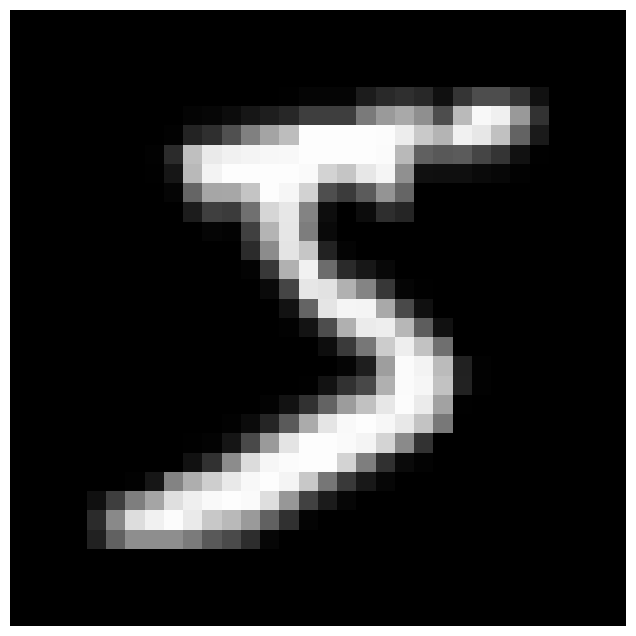

In [76]:
NUM_IMAGES = 1
CIFAR_images = torch.stack([train_dataset_cifar[idx][0] for idx in range(NUM_IMAGES)], dim=0)
MNIST_images = torch.stack([train_dataset_mnist[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = make_grid(MNIST_images, nrow=4)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

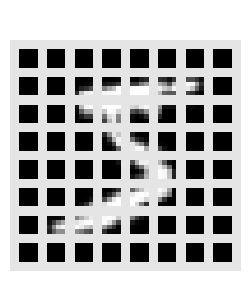

In [77]:
img_patches = img_to_patch(MNIST_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(MNIST_images.shape[0], 1, figsize=(14, 3))
fig.suptitle(" ")
for i in range(CIFAR_images.shape[0]):
    img_grid = make_grid(img_patches[i], nrow=8, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax.imshow(img_grid)  # Fix: Replace ax[i] with ax
    ax.axis("off")
plt.show()
plt.close()

atts: [torch.Size([8, 65, 65]), torch.Size([8, 65, 65]), torch.Size([8, 65, 65]), torch.Size([8, 65, 65])]
torch.Size([1, 32, 32])


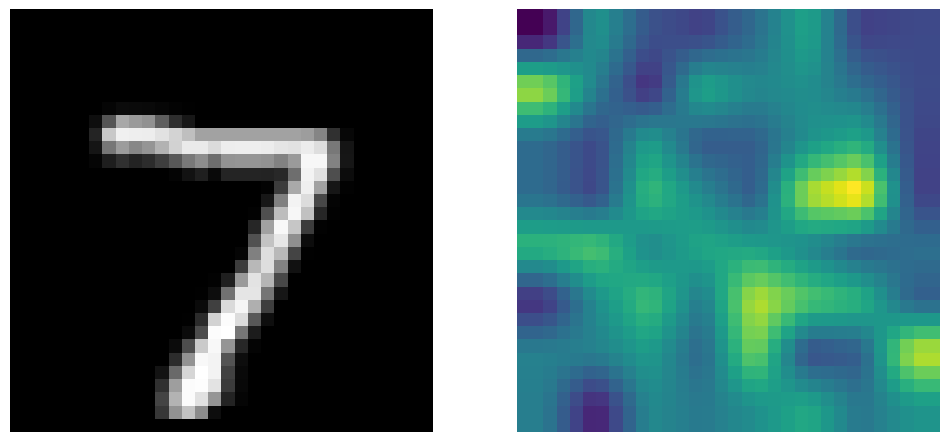

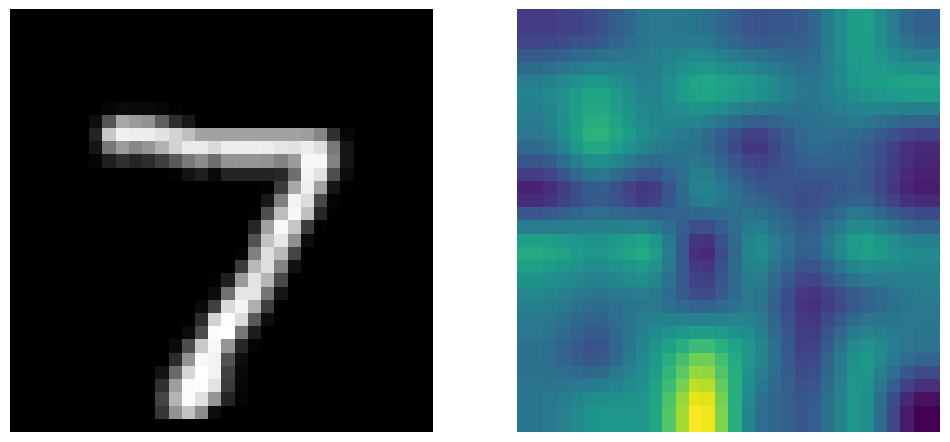

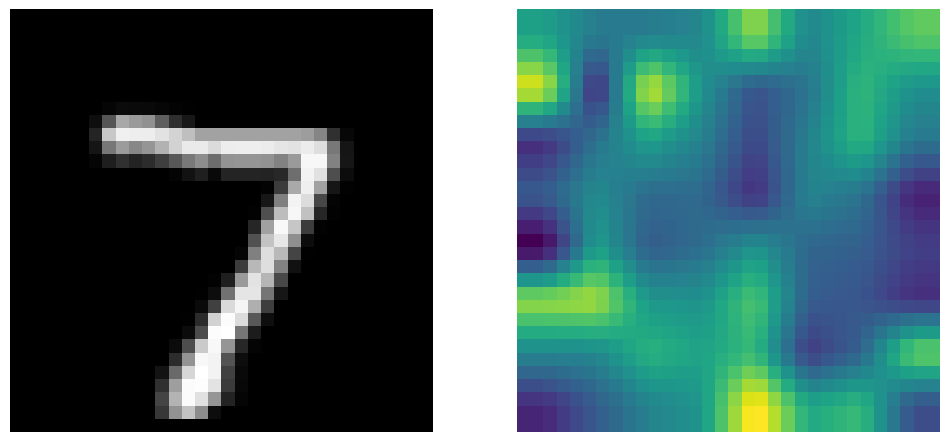

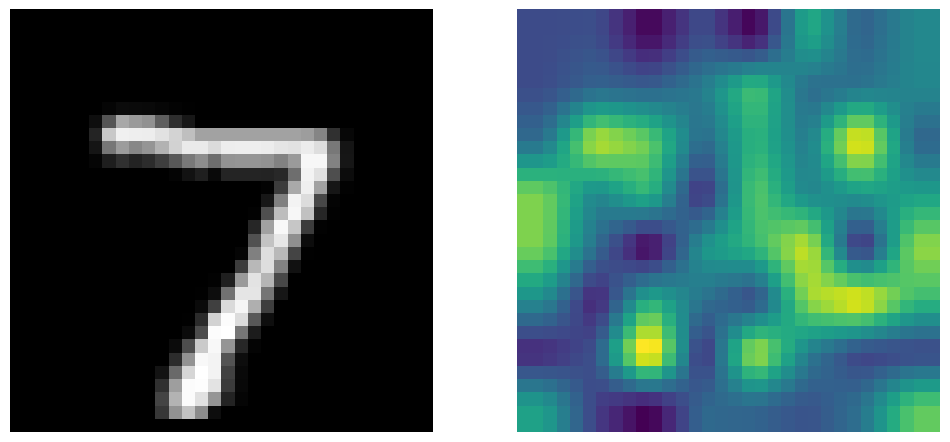

In [59]:
X, y = test_dataset_mnist[0]
X = X.to(device)
pred, tokens, atts = vit(X)
print(f'atts: {[a.squeeze().shape for a in atts]}')
print(X.shape)

for a in atts : 
    attention_matrix_mean = torch.mean(a.squeeze(), dim=0)
    residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
    aug_att_mat = attention_matrix_mean + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    attn_heatmap = joint_attentions[0, 1:].reshape((int(img_size[0]/patch_size[0]), int(img_size[0]/patch_size[0])))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [img_size[0], img_size[0]], mode='bilinear').view(32, 32, 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    img = X.permute(1, 2, 0).squeeze()
    ax1.imshow(img.cpu(), cmap='gray')
    ax1.axis('off')
    ax2.imshow(attn_heatmap_resized.detach().cpu().numpy())
    ax2.axis('off')
